In [6]:
import seaborn as sns
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from process_data import process_mutation_data

%load_ext autoreload
%autoreload 2

from statistical_test import *
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/aoli/repos/zeugma/scripts/process_data.py:112: SyntaxWarning: invalid escape sequence '\#'
  axis.set(ylabel = "\# Increased Branch Coverage")


In [20]:
def violin_plot_for_mutation_distance(df, experiment_name, fig_name, split=True, inner='quart', density_norm='area', width=0.8, x_order=None):
    # tol palette, color-blind friendly
    plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 'axes.grid': True, 'grid.linestyle': '--'})
    plt.rcParams['figure.figsize'] = 7, 3
    custom_palette = {'Zest-all': '#DD8452', 'Zest-saved': '#BEBADA', 'Zeugma-saved': '#BEBADA', 'EI-all': '#4C72B0', 'Zeugma-all': '#4C72B0', 'BeDivFuzz-all': '#4C72B0'}
    tmp_ax = sns.violinplot(data=df, x='benchmark_name', y='mutation', hue='algorithm',
                            split=split, inner=inner, density_norm=density_norm, palette=custom_palette,
                            width=width, linewidth=1.0, order=x_order, common_norm=True, saturation=1, dodge=True)
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
    for l in tmp_ax.lines:
        l.set_linestyle(':')
        l.set_linewidth(1)
        l.set_color('black')
        l.set_alpha(0.8)
    for l in tmp_ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.6)
        l.set_color('#F7F056')
        l.set_alpha(0.8)

    # get rid of ticks for empty columns (levels)
    if x_order:
        x_arr = np.array(x_order)
        position_arr = np.array(range(0, len(x_order)))
        positions = [p for p, order in zip(position_arr, x_arr) if 'NA' not in order]
        filtered_x = [e for e in list(x_order) if 'NA' not in e]
        tmp_ax.set_xticks(positions)
        tmp_ax.set_xticklabels(filtered_x)
        plt.xticks(rotation=30)

    tmp_ax.set(xlabel='Benchmark', ylabel='Mutation Distance (%)')
    # tmp_ax.grid(False)
    plt.savefig('./figs/{}_{}.pdf'.format(experiment_name, fig_name), bbox_inches='tight', pad_inches=0.1)

In [8]:
def box_plot_for_mutation_distance(df, experiment_name, fig_name):
    tmp_ax = sns.boxplot(data=df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [9]:
def beautify_stats_table(groupby):
    stats = groupby.describe()
    processed_stats = stats.loc[:, (slice(None), ['', 'count', '50%', 'mean', 'std', 'min', 'max'])].rename(columns={'50%':'median'})
    return processed_stats

def bar_plot_for_median_mutation_distance(stats_df, experiment_name, fig_name):
    # get the median values
    median_mutation_df = stats_df.loc[:, (slice(None), ['', 'median'])]
    # flatten the index
    median_mutation_df.columns = median_mutation_df.columns.get_level_values(0)
    # reorder the index
    # median_mutation_df = median_mutation_df.reindex([0, 5, 6, 1, 2, 3, 4, 7, 12, 13, 8, 9, 10, 11]).reset_index(drop=True)
    # bar plot
    tmp_ax = sns.barplot(median_mutation_df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [10]:
# statistical tests
def mann_whitney_u_test_for_mutation_distance(df, groupby, alg1_name, alg2_name):
    # TODO: remove either df or groupby
    result_dict = {}
    test_names = ['two-sided', 'less']
    measures = ['p', 'A_12', 'U1', 'U2', 'r1', 'r2']
    indices = []
    for name in test_names:
        indices += ['{}_{}'.format(name, measure) for measure in measures]

    # Warning: large and unequal sample sizes will result in timeout; debugging required
    for benchmark_name in df.benchmark_name.unique():
        print('testing {}...'.format(benchmark_name))
        alg1_data = groupby.get_group((alg1_name, benchmark_name)).mutation.values
        alg2_data = groupby.get_group((alg2_name, benchmark_name)).mutation.values
        print('sample1 size: {}, sample2 size: {}'.format(len(alg1_data), len(alg2_data)))
        result_two_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[0], verbose=False)
        result_one_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[1], verbose=False)
        result_dict[benchmark_name] = list(result_two_sided) + list(result_one_sided)
    # create the dataframe
    stats_df = pd.DataFrame(result_dict, index=indices)
    return stats_df

In [13]:
process_mutation_data("/data/aoli/havoc_eval/havoc-test", [False, True], ["zest", "ei", "bedivfuzz-simple", "bedivfuzz-structure", "zeugma-linked"], 'mutation_string', "")
process_mutation_data("/data/aoli/havoc_eval/havoc-test", [False, True], ["zest", "ei", "bedivfuzz-simple", "bedivfuzz-structure", "zeugma-linked"], 'mutation_byte', "byte_")

processing ant...
processing maven...
processing rhino...
processing closure...
processing chocopy...
processing gson...
processing jackson...
creating dataframe...
processing ant...
processing maven...
processing rhino...
processing closure...
processing chocopy...
processing gson...
processing jackson...
creating dataframe...


In [ ]:
mutation_df = pd.read_pickle("./mutation_string.pkl")
display(mutation_df)
new_label_names = {
    'zest': 'Zest-all',
    'zest-saved_only': 'Zest-saved',
    'ei': 'EI-all',
    'ei-saved_only': 'EI-saved',
    'zeugma-linked': 'Zeugma-all',
    'zeugma-linked-saved_only': 'Zeugma-saved',
    'bedivfuzz-structure': 'BeDivFuzz-all',
    'bedivfuzz-structure-saved_only': 'BeDivFuzz-saved',
    }
mutation_df['algorithm'] = mutation_df['algorithm'].map(new_label_names)
mutation_df = mutation_df.dropna()
zest_df = mutation_df[mutation_df['algorithm'].str.contains('Zest')]
# ei_df = mutation_df[~mutation_df.index.isin(zest_df.index)]
all_input_df = mutation_df[mutation_df['algorithm'].str.contains('all')]

,mutation,algorithm,benchmark_name
0,0.005658,zest,ant
1,0.734328,zest,ant
2,0.415663,zest,ant
3,0.083333,zest,ant
4,0.311475,zest,ant
...,...,...,...
1914420,0.040745,zeugma-linked-saved_only,jackson
1914421,0.000000,zeugma-linked-saved_only,jackson
1914422,0.030928,zeugma-linked-saved_only,jackson
1914423,0.014732,zeugma-linked-saved_only,jackson


,mutation,algorithm,benchmark_name
0,0.005658,Zest-all,ant
1,0.734328,Zest-all,ant
2,0.415663,Zest-all,ant
3,0.083333,Zest-all,ant
4,0.311475,Zest-all,ant
...,...,...,...
1914420,0.040745,Zeugma-saved,jackson
1914421,0.000000,Zeugma-saved,jackson
1914422,0.030928,Zeugma-saved,jackson
1914423,0.014732,Zeugma-saved,jackson


In [36]:
non_zero_mutation_df = mutation_df[mutation_df['mutation'] != 0]
non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]


/tmp/ipykernel_1169949/2044483683.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
/tmp/ipykernel_1169949/2044483683.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]


# Mutation Distance (String Distance)

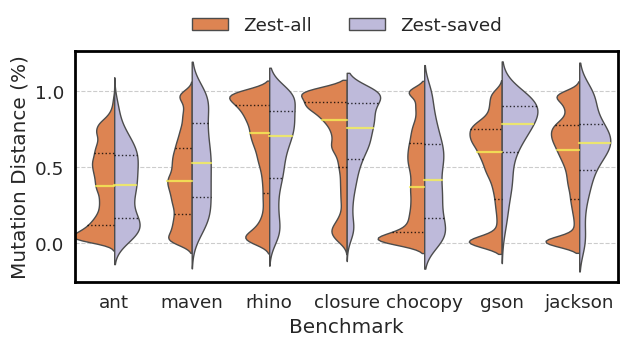

In [16]:
violin_plot_for_mutation_distance(non_zero_zest_df, "t1", 'rq1_wo_zero_mutations', width=1.2)

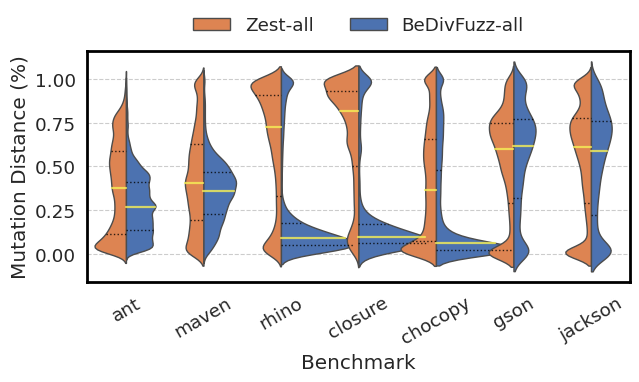

In [17]:
x_order = ('ant', 'maven', 'rhino', 'closure', 'chocopy', 'gson', 'jackson')
zest_versus_bedivfuzz = non_zero_all_input_df[non_zero_all_input_df['algorithm'].str.contains('Zest|BeDivFuzz')]
violin_plot_for_mutation_distance(zest_versus_bedivfuzz, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

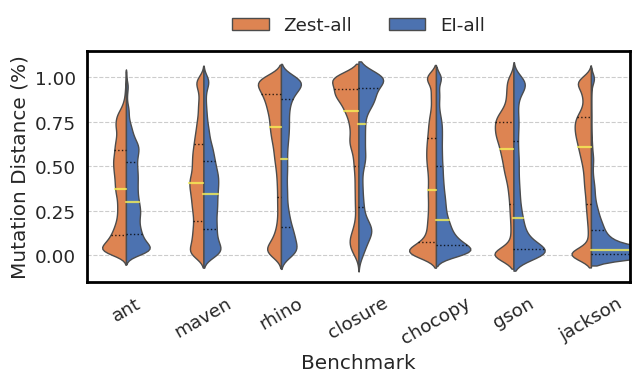

In [18]:
zest_versus_ei = non_zero_all_input_df[non_zero_all_input_df['algorithm'].str.contains('Zest|EI')]
violin_plot_for_mutation_distance(zest_versus_ei, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

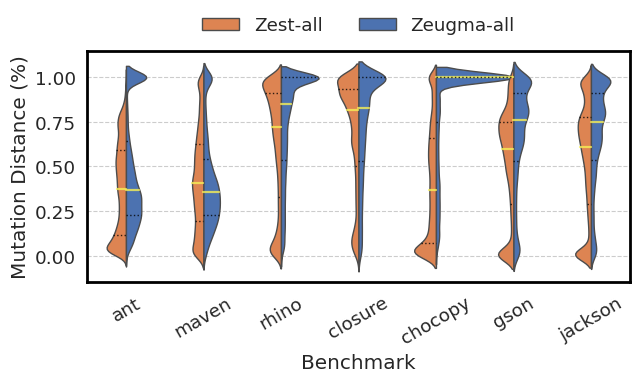

In [19]:
zest_versus_zeugma = non_zero_all_input_df[non_zero_all_input_df['algorithm'].str.contains('Zest|Zeugma')]
violin_plot_for_mutation_distance(zest_versus_zeugma, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

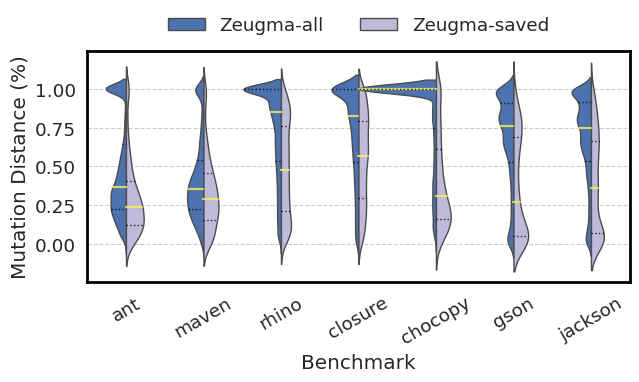

In [38]:
non_zero_zeugma_df = non_zero_mutation_df[non_zero_mutation_df['algorithm'].str.contains('Zeugma')]
violin_plot_for_mutation_distance(non_zero_zeugma_df, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

# Mutation Distance (Parametric/Byte Distance)

In [51]:
byte_mutation_df = pd.read_pickle("./mutation_byte.pkl")
byte_mutation_df['algorithm'] = byte_mutation_df['algorithm'].map(new_label_names)
byte_mutation_df = byte_mutation_df.dropna()

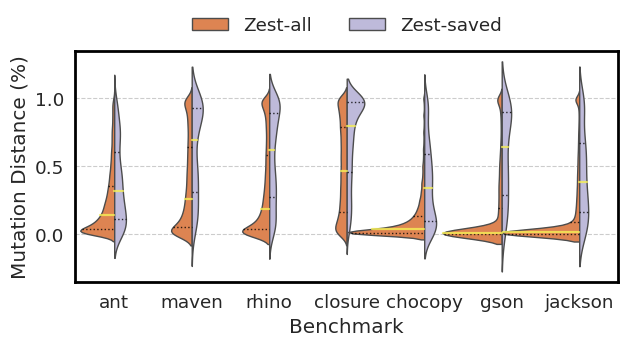

In [52]:
non_zero_zest_df = byte_mutation_df[byte_mutation_df['algorithm'].str.contains('Zest')]
violin_plot_for_mutation_distance(non_zero_zest_df, "t1", 'rq1_wo_zero_mutations', width=2.0)

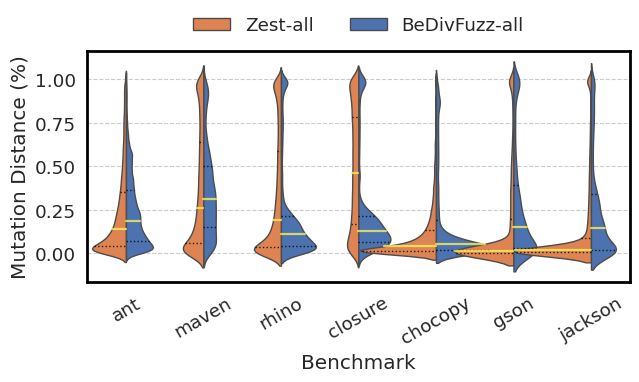

In [ ]:
byte_mutation_df_all = byte_mutation_df[byte_mutation_df['algorithm'].str.contains('all')]
zest_versus_bedivfuzz = byte_mutation_df_all[byte_mutation_df_all['algorithm'].str.contains('Zest|BeDivFuzz')]
violin_plot_for_mutation_distance(zest_versus_bedivfuzz, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

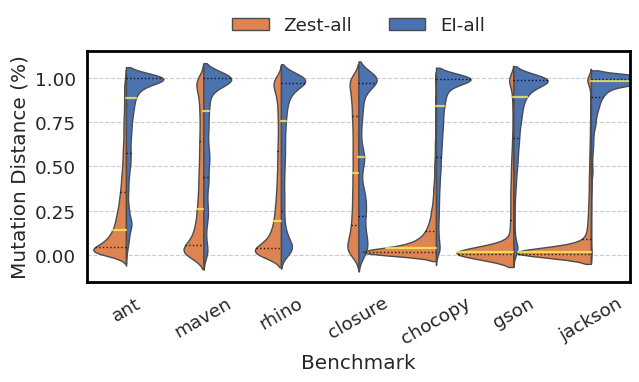

In [56]:
zest_versus_ei = byte_mutation_df_all[byte_mutation_df_all['algorithm'].str.contains('Zest|EI')]
violin_plot_for_mutation_distance(zest_versus_ei, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

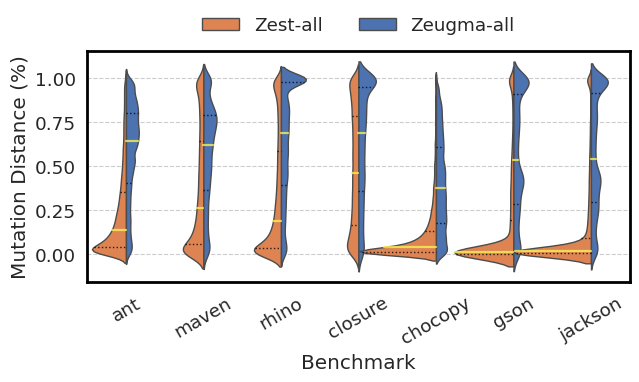

In [57]:
zest_versus_zeugma = byte_mutation_df_all[byte_mutation_df_all['algorithm'].str.contains('Zest|Zeugma')]
violin_plot_for_mutation_distance(zest_versus_zeugma, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)